
from scipy.interpolate import interp1d





This is an extension, which uses numba JIT compilation; faster

In [10]:
%matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from interpolation import interp
from numba import jit, njit, prange, float64, int32
from numba.experimental import jitclass
from quantecon.optimize.scalar_maximization import brent_max

In [11]:
def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

In [17]:
opt_growth_data = [
    ('alpha', float64),          # Production parameter
    ('beta', float64),          # Discount factor
    ('mu', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                alpha=0.4,
                beta=0.96,
                mu=0,
                s=0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(mu + s * np.random.randn(shock_size))


    def f(self, k):
        "The production function"
        return k**self.alpha

    def u(self, c):
        "The utility function"
        return np.log(c)

    def f_prime(self, k):
        self.alpha * (k ** (self.alpha-1))

    def u_prime(self, c):
        return 1/c

    def u_prime_inv(self, c):
        return 1/c

In [42]:
@njit
def state_action_value(c, y, v_array, og):
    v = lambda x: interp(og.grid, v_array, x)
    return og.u(c) + og.beta * np.mean(v(og.f(y-c) * og.shocks))

In [43]:
@njit
def T(v, og):
    v_greedy = np.empty_like(v)
    v_new = np.empty_like(v)

    for i in range(len(og.grid)):
        y = og.grid[i]

        result = brent_max(state_action_value, 1e-10, y, (y, v, og))
        v_greedy[i], v_new[i] = result[0], result[1]

    return v_greedy, v_new

In [44]:
def solve_model(og, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    """
    Solve model by iterating with the Bellman operator.

    """

    # Set up loop
    v = og.u(og.grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_greedy, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new

In [45]:
og = OptimalGrowthModel()

In [46]:
%%time
v_greedy, v_solution = solve_model(og)

Error at iteration 25 is 0.41372668361362486.
Error at iteration 50 is 0.14767653072604503.
Error at iteration 75 is 0.053221715530355596.
Error at iteration 100 is 0.019180931418517844.
Error at iteration 125 is 0.0069127447095027605.
Error at iteration 150 is 0.002491330497829125.
Error at iteration 175 is 0.0008978673320463315.
Error at iteration 200 is 0.00032358843869317866.
Error at iteration 225 is 0.00011662021096014996.

Converged in 229 iterations.
CPU times: total: 1.77 s
Wall time: 1.75 s


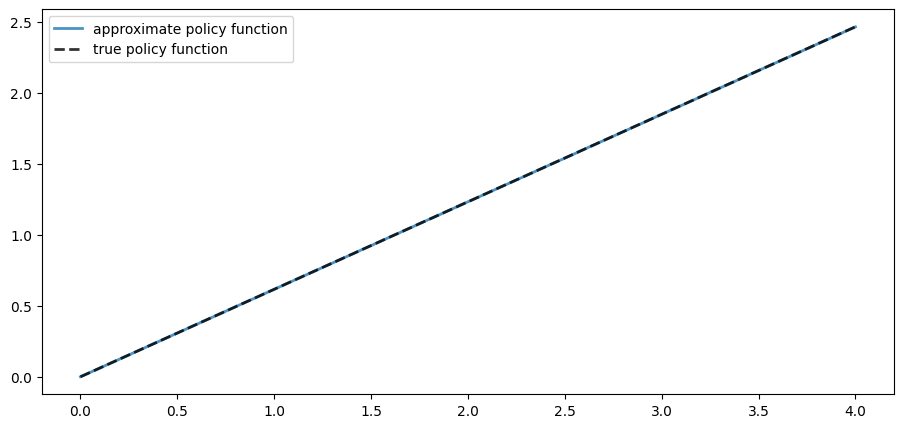

In [47]:
fig, ax = plt.subplots()

ax.plot(og.grid, v_greedy, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(og.grid, σ_star(og.grid, og.alpha, og.beta), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()